This colab is what we used to do our Data collection. We colelcted image data paired with locations to use to train our model. We started out by following the structure of the data collection from our source project. In the source project they first obtained a shapefile of US, then split the shapefile into 243 grids. They found 20 random locations in each grid, and found 3 images per location, correlating with 0 degrees, 90 degrees and 180 degrees.

We then found a shapefile for the UK and split it up into 246 grids. We then simillarly found 20 random locations in each grid, and found 3 images per location, correlating with 0 degrees, 90 degrees and 180 degrees.

After collecting this data we manually went through many images and found that the images were lacking information on cities and had a lot of rural locations with very little information to train on. To address this we created a CSV with the top 100 cities by population in the US and top 50 cities by population in the UK in order to augment our data. We found 20 random locations within these cities and found 3 images per location, correlating with 0 degrees, 90 degrees and 180 degrees.

After training on the above data in the UK we found that we were still plateauing in terms of capability. We decided to create another dataset focused entirely on cities. Here we found the top 150 cities in the UK by population. For the top 50, we found 200 locations, for the middle 50 we found 100 locations and for the bottom 50 we found 50 locations. We then found 3 images per location, correlating with 0 degrees, 90 degrees and 180 degrees. We also set the streeview api parameters to only include outdoor images to try to reduce noise (though still some indoor images slipped through)

Finally we realized that in our previous CSV's for the top UK cities we were missing some major cities such as Edinburgh, Leeds and Glasgow. This was a complete oversight on our part, but did give us an opportunity to expand our dataset even more. We decided to make a new top 50 uk cities dataset, with 200 locations for each city with a slightly tighter radius. We then removed our previous top 50 cities in the original Uk dataset. While it was hard to find a consensus top 50 cities in the UK this dataset was much more accurate. We then used this dataset to try to  achieve our most accurate model so far.


Grid US: 243 * 20 * 3 = 14580 Images
Grid UK: 246 * 20 * 3 = 14760 Images

Addition US cities: 100 * 20 * 3 = 6000 Images
Top 150 UK cities: (50 * 200 * 3) + (50 * 100 * 3) + (50 * 50 * 3) = 52500 Images

Final uk cities: 50 * 200 * 3 = 30000

#Overall we were able to create a more expansive dataset of 117840 images paired with locations across the US and UK as well as extensive data on cities.

Credit to Nirvan S.P. Theethira for the source code which we used and built off of

Preprocessing steps

In [54]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np
import pickle
from google.colab import drive


In [55]:
!pip install shapely==1.8



In [56]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading in US shapefile

In [57]:
states_gdf = gpd.read_file('/content/drive/My Drive/shapeFileUS/cb_2018_us_nation_5m.shp')
states_gdf

AFFGEOID GEOID           NAME  \
0  0100000US    US  United States   

                                            geometry  
0  MULTIPOLYGON (((179.48246 51.98283, 179.48656 ...

Find Mainland US

<ipython-input-58-747d12147f88>:3: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in states_gdf['geometry'][0]:


Mainland at polygon 146 


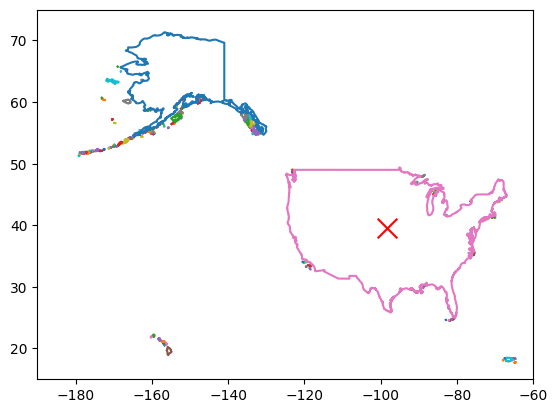

In [58]:
usaCenter = Point(-98.35,39.50)
idx = 0
for polygon in states_gdf['geometry'][0]:
    x,y = polygon.exterior.xy
    plt.plot(x,y)
    if usaCenter.within(polygon):
        usaPoly = np.array([(yi,xi) for xi,yi in zip(x,y)])
        print("Mainland at polygon {} ".format(idx))
    idx+=1
plt.scatter([-98.35], [39.50], c='r', marker='x', s=200)
plt.xlim([-190,-60])
plt.ylim([15,75])
plt.show()

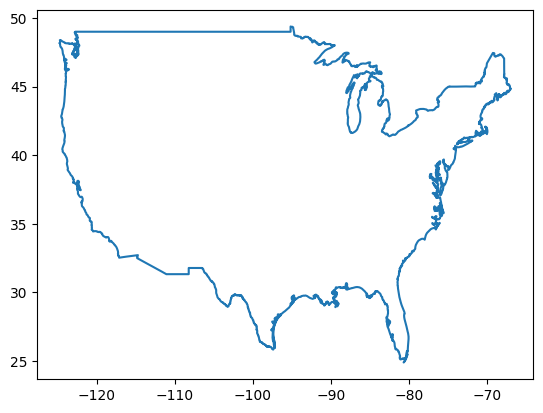

array([[  48.169997, -124.731746],
       [  48.184422, -124.704153],
       [  48.198599, -124.696111],
       ...,
       [  48.160402, -124.731703],
       [  48.163393, -124.733174],
       [  48.169997, -124.731746]])

In [59]:
plt.plot(usaPoly[:,1],usaPoly[:,0])
plt.show()
usaPoly

Save Shapefile

In [60]:
pickle.dump(usaPoly,open("/content/drive/My Drive/usaPoly.pkl","wb"))

In [61]:
# prompt: pip install gmaps

!pip install gmaps


In [62]:
import shapely
import gmaps
from shapely.geometry import Point, Polygon, box
from matplotlib import pyplot as plt
import numpy as np
import pickle

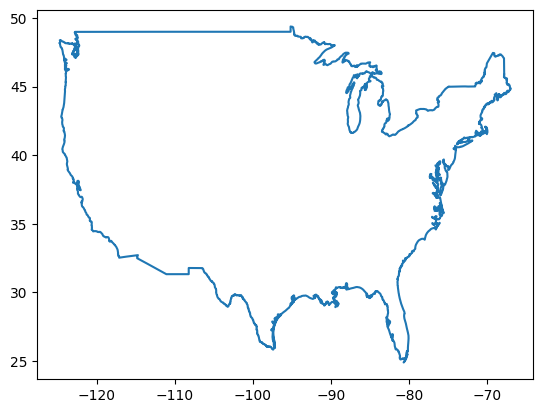

In [63]:
usaPoly = pickle.load(open("/content/drive/My Drive/usaPoly.pkl",'rb'))
usaPoly = Polygon(np.flip(usaPoly))
x,y = usaPoly.exterior.xy
plt.plot(x,y)

Split file into grids

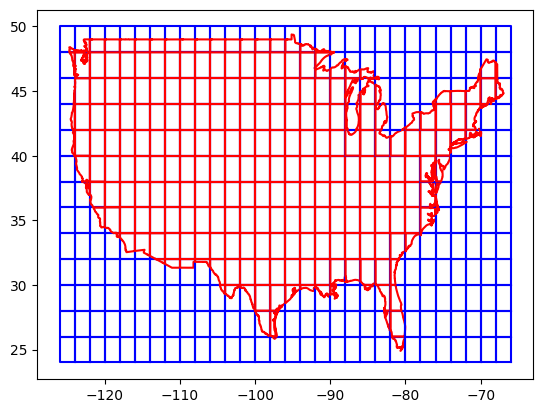

In [64]:
dim = 2
bounds = usaPoly.bounds
xmin = int(bounds[0] // dim)
xmax = int(bounds[2] // dim)
ymin = int(bounds[1] // dim)
ymax = int(bounds[3] // dim)
for i in range(xmin, xmax+1):
    for j in range(ymin, ymax+1):
        b = box(i*dim, j*dim, (i+1)*dim, (j+1)*dim)
        g = usaPoly.intersection(b)
        x,y = b.exterior.xy
        plt.plot(x,y,c='b')
        if g.is_empty:
            continue
        if type(g)==shapely.geometry.multipolygon.MultiPolygon:
            for gems in g.geoms:
                x,y = gems.exterior.xy
                plt.plot(x,y,c='r')
        else:
            x,y = g.exterior.xy
            plt.plot(x,y,c='r')
plt.show()

Partition grids to be in bounds of the US

In [65]:
def partition(polygon, dim, mergeFactor=0.1):
    '''
    polygon: Unsplit polygon of mainland US
    dim: The dimensions of each grid to split the map into
    mergeFactor: threshold of smallest grid.
    Any grid smaller will be combined with neighbouring grids
    '''
    bounds = polygon.bounds
    xmin = int(bounds[0] // dim)
    xmax = int(bounds[2] // dim)
    ymin = int(bounds[1] // dim)
    ymax = int(bounds[3] // dim)
    grid = 0
    res = []
    for i in range(xmin, xmax+1):
        for j in range(ymin, ymax+1):
            b = box(i*dim, j*dim, (i+1)*dim, (j+1)*dim)
            g = polygon.intersection(b)
            if g.is_empty:
                continue
            if type(g)==shapely.geometry.multipolygon.MultiPolygon:
                for gems in g.geoms:
                    res.append(gems)
                    grid += 1
            else:
                res.append(g)
                grid += 1
    return merge(res, mergeFactor)

def merge(polyList, mergeFactor=0.1):
    '''
    polyList: list of polygon grids the map is split into
    mergeFactor: threshold of smallest grid.
    Any grid smaller will be combined with neighbouring grids
    '''
    def combine(pidx, polyL):
        p = polyL[pidx]
        del polyL[pidx]
        for idx,i in enumerate(polyL):
            u = p.union(i)
            if p.intersects(i) and type(u)!=shapely.geometry.multipolygon.MultiPolygon:
                polyL[idx] = u
                break
        return polyL

    mnLimit = max(polyList, key=lambda x:x.area).area * mergeFactor
    mnPoly = min(polyList, key=lambda x:x.area)
    while(mnPoly.area<=mnLimit):
        polyList = combine(polyList.index(mnPoly), polyList)
        mnPoly = min(polyList, key=lambda x:x.area)

    result = {}
    for idx,i in enumerate(polyList):
        x,y = i.exterior.xy
        result[idx] = np.array([(y,x) for x,y in zip(x,y)])
    return result

def plotMap(polyGrid):
    gPoly = []
    gMarkLoc = []
    gMarkInf = []
    info_box_template = """
    <dl>
    <dd>{}</dd>
    </dl>
    """
    for k,v in polyGrid.items():
        gPoly.append(gmaps.Polygon(
                        list(v),
                        stroke_color='red',
                        fill_color='blue'
                        ))
        gMarkLoc.append((v[0][0],v[0][1]))
        gMarkInf.append(info_box_template.format(k))
    fig = gmaps.figure(center=(39.50,-98.35), zoom_level=4, map_type='TERRAIN')
    fig.add_layer(gmaps.drawing_layer(features=gPoly))
#     fig.add_layer(gmaps.marker_layer(gMarkLoc, info_box_content=gMarkInf))
    return fig

In [66]:
usaPolyGrid = partition(usaPoly, 2, mergeFactor=0.1)

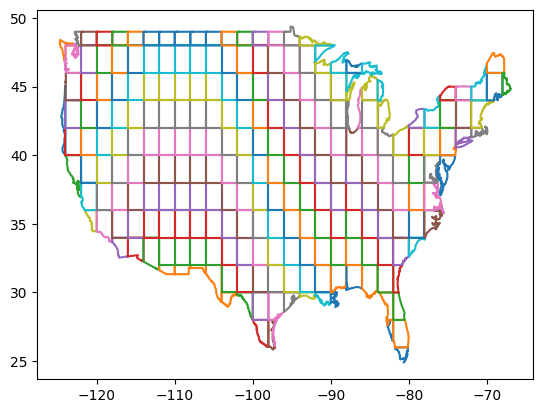

243

In [67]:
for i in usaPolyGrid.values():
    plt.plot(i[:,1],i[:,0])
plt.show()
len(usaPolyGrid)

In [68]:
pickle.dump(usaPolyGrid,open("/content/drive/My Drive/usaPolyGrid.pkl","wb"))

Repeat steps for UK

In [69]:
england_gdf = gpd.read_file('/content/drive/My Drive/shapeFileGB/GBR_adm0.shp')
england_gdf

ID_0  ISO          NAME_0  OBJECTID_1 ISO3      NAME_ENGLI        NAME_ISO  \
0   242  GBR  United Kingdom          82  GBR  United Kingdom  UNITED KINGDOM   

         NAME_FAO      NAME_LOCAL NAME_OBSOL  ... CARICOM   EU  CAN  ACP  \
0  United Kingdom  United Kingdom       None  ...     0.0  1.0  0.0  0.0   

  Landlocked AOSIS SIDS Islands  LDC  \
0        0.0   0.0  0.0     0.0  0.0   

                                            geometry  
0  MULTIPOLYGON (((-6.38792 49.86875, -6.38792 49...  

[1 rows x 71 columns]

<ipython-input-70-9653e7726836>:4: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in england_gdf['geometry'][0]:


Mainland at polygon 815 


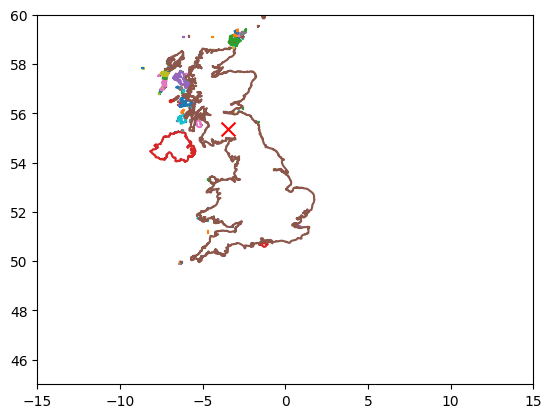

In [70]:
ukCenter = Point(-3.44,55.38)

idx = 0
for polygon in england_gdf['geometry'][0]:
    x,y = polygon.exterior.xy
    plt.plot(x,y)
    if ukCenter.within(polygon):
        ukPoly = np.array([(yi,xi) for xi,yi in zip(x,y)])
        print("Mainland at polygon {} ".format(idx))
    idx+=1
plt.scatter([-3.44], [55.38], c='r', marker='x', s=100)
plt.xlim([-15,15])
plt.ylim([45,60])

plt.show()

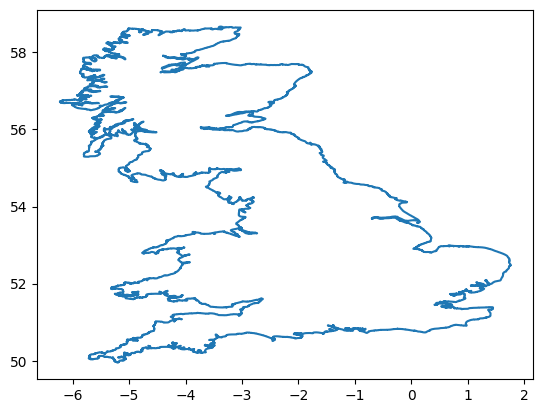

array([[55.72986221, -4.88527679],
       [55.72958374, -4.88527679],
       [55.72958374, -4.8836112 ],
       ...,
       [55.72874832, -4.88583279],
       [55.72986221, -4.88583279],
       [55.72986221, -4.88527679]])

In [71]:
plt.plot(ukPoly[:,1],ukPoly[:,0])
plt.show()
ukPoly

In [72]:
pickle.dump(ukPoly,open("/content/drive/My Drive/ukPoly.pkl","wb"))

In [73]:
import shapely
import gmaps
from shapely.geometry import Point, Polygon, box
from matplotlib import pyplot as plt
import numpy as np
import pickle

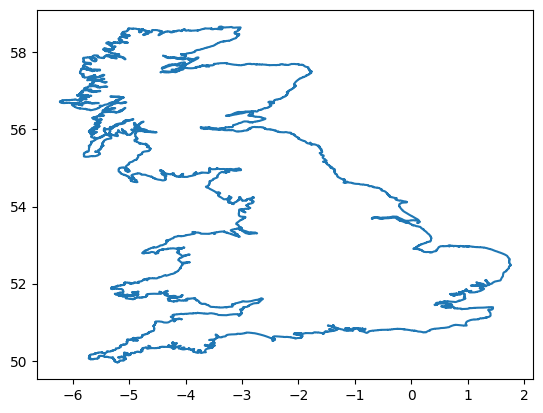

In [74]:
ukPoly = pickle.load(open("/content/drive/My Drive/ukPoly.pkl",'rb'))
ukPoly = Polygon(np.flip(ukPoly))
x,y = ukPoly.exterior.xy
plt.plot(x,y)

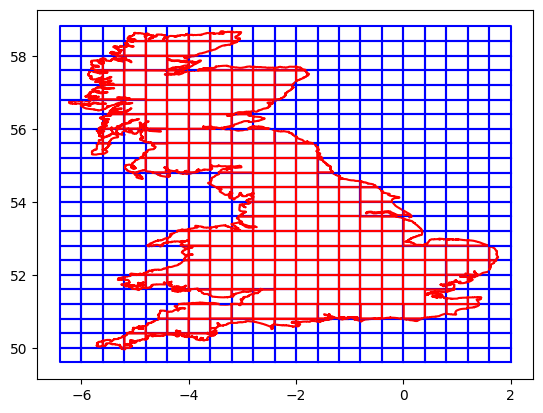

In [75]:
dim = 0.4
bounds = ukPoly.bounds
xmin = int(bounds[0] // dim)
xmax = int(bounds[2] // dim)
ymin = int(bounds[1] // dim)
ymax = int(bounds[3] // dim)
for i in range(xmin, xmax+1):
    for j in range(ymin, ymax+1):
        b = box(i*dim, j*dim, (i+1)*dim, (j+1)*dim)
        g = ukPoly.intersection(b)
        x,y = b.exterior.xy
        plt.plot(x,y,c='b')
        if g.is_empty:
            continue
        if type(g)==shapely.geometry.multipolygon.MultiPolygon:
            for gems in g.geoms:
                x,y = gems.exterior.xy
                plt.plot(x,y,c='r')
        else:
            x,y = g.exterior.xy
            plt.plot(x,y,c='r')
plt.show()

In [76]:
def partition(polygon, dim, mergeFactor=0.1):
    '''
    polygon: Unsplit polygon of mainland US
    dim: The dimensions of each grid to split the map into
    mergeFactor: threshold of smallest grid.
    Any grid smaller will be combined with neighbouring grids
    '''
    bounds = polygon.bounds
    xmin = int(bounds[0] // dim)
    xmax = int(bounds[2] // dim)
    ymin = int(bounds[1] // dim)
    ymax = int(bounds[3] // dim)
    grid = 0
    res = []
    for i in range(xmin, xmax+1):
        for j in range(ymin, ymax+1):
            b = box(i*dim, j*dim, (i+1)*dim, (j+1)*dim)
            g = polygon.intersection(b)
            if g.is_empty:
                continue
            if type(g)==shapely.geometry.multipolygon.MultiPolygon:
                for gems in g.geoms:
                    res.append(gems)
                    grid += 1
            else:
                res.append(g)
                grid += 1
    return merge(res, mergeFactor)

def merge(polyList, mergeFactor=0.1):
    '''
    polyList: list of polygon grids the map is split into
    mergeFactor: threshold of smallest grid.
    Any grid smaller will be combined with neighbouring grids
    '''
    def combine(pidx, polyL):
        p = polyL[pidx]
        del polyL[pidx]
        for idx,i in enumerate(polyL):
            u = p.union(i)
            if p.intersects(i) and type(u)!=shapely.geometry.multipolygon.MultiPolygon:
                polyL[idx] = u
                break
        return polyL

    mnLimit = max(polyList, key=lambda x:x.area).area * mergeFactor
    mnPoly = min(polyList, key=lambda x:x.area)
    while(mnPoly.area<=mnLimit):
        polyList = combine(polyList.index(mnPoly), polyList)
        mnPoly = min(polyList, key=lambda x:x.area)

    result = {}
    for idx,i in enumerate(polyList):
        x,y = i.exterior.xy
        result[idx] = np.array([(y,x) for x,y in zip(x,y)])
    return result

def plotMap(polyGrid):
    gPoly = []
    gMarkLoc = []
    gMarkInf = []
    info_box_template = """
    <dl>
    <dd>{}</dd>
    </dl>
    """
    for k,v in polyGrid.items():
        gPoly.append(gmaps.Polygon(
                        list(v),
                        stroke_color='red',
                        fill_color='blue'
                        ))
        gMarkLoc.append((v[0][0],v[0][1]))
        gMarkInf.append(info_box_template.format(k))
    fig = gmaps.figure(center=(39.50,-98.35), zoom_level=4, map_type='TERRAIN')
    fig.add_layer(gmaps.drawing_layer(features=gPoly))
#     fig.add_layer(gmaps.marker_layer(gMarkLoc, info_box_content=gMarkInf))
    return fig

In [77]:
ukPolyGrid = partition(ukPoly, dim, mergeFactor=0.1)

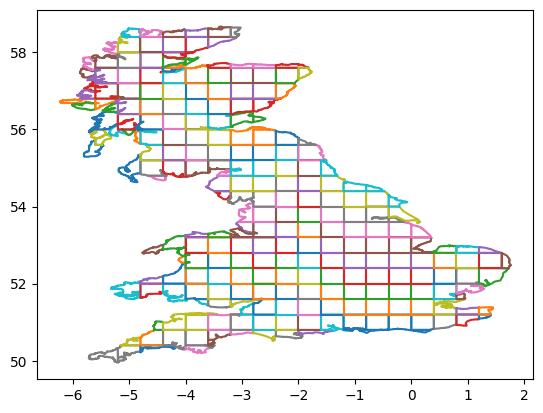

246

In [78]:
for i in ukPolyGrid.values():
    plt.plot(i[:,1],i[:,0])
plt.show()
len(ukPolyGrid)

In [79]:
pickle.dump(ukPolyGrid,open("/content/drive/My Drive/ukPolyGrid.pkl","wb"))

#DATA COLLECTION

In [80]:
from google.colab import userdata
import requests
import json, os
import urllib.request
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
import shapely
import pickle
import random
import numpy as np
import gmaps
api = userdata.get('secret')

In [81]:
dataDir = "/content/drive/My Drive/data/"

In [82]:
# used to plot collected data points
def plotMap(polyGrid, Loc=[], restrict=[]):
    gPoly = []
    sLoc = []
    sHtext = []
    if len(restrict)==0:
        restrict = list(polyGrid.keys())

    for k,v in polyGrid.items():
        if k in restrict:
            gPoly.append(gmaps.Polygon(
                            list(v),
                            stroke_color='red',
                            fill_color='blue'
                            ))
            sLoc.append((v[0][0],v[0][1]))
            sHtext.append(str(k))

    if len(Loc)!=0:
        sLoc = []
        sHtext = []
        for k,v in Loc.items():
            if k in restrict:
                sLoc += v
                sHtext += [str(k)+str(i) for i in v]

    fig = gmaps.figure(center=(39.50,-98.35), zoom_level=4, map_type='TERRAIN')
    fig.add_layer(gmaps.drawing_layer(features=gPoly))
    fig.add_layer(gmaps.symbol_layer(sLoc,info_box_content = sHtext, scale = 1))
    return fig

#USA scrape by grid

In [83]:
searchGrids = usaPolyGrid.keys()
print("Seacrchin Grids: {}".format("All" if searchGrids==usaPolyGrid.keys() else searchGrids))

Seacrchin Grids: All


In [84]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geopy")

In [85]:
base = 'https://maps.googleapis.com/maps/api/streetview'
ext = '?size=600x300&location={}&fov=100&heading={}&radius={}&pitch=10&key={}'
print("Seacrchin Grids: {}".format("All" if searchGrids==usaPolyGrid.keys() else searchGrids))
for grid,coor in usaPolyGrid.items():
    poly = Polygon(np.flip(coor))
    minx, miny, maxx, maxy = poly.bounds
    count = 0
    trials = 0
    locList = []
    if grid in searchGrids:
        saveFolder = dataDir + '/{}'.format(grid)
        if os.path.exists(saveFolder)==False:
            os.mkdir(saveFolder)
        locList = os.listdir(saveFolder)
        print("################## Searching grid {} ###################".format(grid))
        print("Save folder {}".format(saveFolder))
        print("Existing locations {}".format(locList))
        directory_count = len([entry for entry in locList if os.path.isdir(os.path.join(saveFolder, entry))])
        while count<20 and trials<10 and directory_count<20:
            pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            location = str(pnt.y)+','+str(pnt.x)
            if (poly.contains(pnt)) and (location not in locList):
                metaUrl = base + '/metadata' + ext.format(location, 0, 10000, api)
                r = requests.get(metaUrl).json()
                trials += 1
                print("Trial: {}, count: {}".format(trials,count))
                if r['status']=='OK' and poly.contains(Point(r['location']['lng'],r['location']['lat'])):
                    location = str(r['location']['lat'])+','+str(r['location']['lng'])
                    if (location not in locList):
                        print("Valid location found: {}".format(location))
                        locList.append(location)
                        saveFile = saveFolder + "/{}".format(location)
                        if os.path.exists(saveFile)==False:
                            os.mkdir(saveFile)
                        for heading in [0,90,180]:
                            imgUrl = base + ext.format(location, heading, 10000, api)
                            urllib.request.urlretrieve(imgUrl,saveFile+'/{}_{}.jpg'.format(heading,r['date']))
                        count += 1
                        trials = 0
                    else:
                        print("Failed trial {} location exists".format(trials))
                        print("Location {}".format(location))
                else:
                    print("Failed trial {} status or contains".format(trials))
                    print("Location {}".format(location))
        print(locList)
        print("No duplicates: {}".format(len(locList)==len(set(locList))))
        print("########## Final locations for grid {}: {} ############".format(grid, len(locList)))

Seacrchin Grids: All
################## Searching grid 0 ###################
Save folder /content/drive/My Drive/data//0
Existing locations ['42.90271257645868,-124.4588075901842', '43.20281087484201,-124.2596917373695', '41.84069465888159,-124.109890257072', '40.69014596759436,-124.2704306566252', '43.5724121,-124.1699706', '42.815249,-124.4119913', '40.61004378170814,-124.1461124264584', '42.1643583,-124.1424467', '42.97246253203624,-124.4261342507332', '40.2524691,-124.3212829', '42.48942156634426,-124.235580867203', '40.34142180941781,-124.3175771794493', '42.47007300148828,-124.3835660345345', '41.90418218627549,-124.1463333861289', '40.5403139573009,-124.2788191363442', '40.4742813,-124.1092148', '43.10249585909416,-124.2716425762885', '40.2161558151947,-124.1075750910506', '40.46294778959515,-124.0903516682383', '43.32680794857047,-124.1845068690775']
['42.90271257645868,-124.4588075901842', '43.20281087484201,-124.2596917373695', '41.84069465888159,-124.109890257072', '40.69014

#UK Scrape by grid

In [86]:
searchGridsUK = ukPolyGrid.keys()
print("Seacrchin Grids: {}".format("All" if searchGridsUK==ukPolyGrid.keys() else searchGridsUK))

Seacrchin Grids: All


In [87]:
dataDirUK = "/content/drive/My Drive/dataUK/"

In [88]:
base = 'https://maps.googleapis.com/maps/api/streetview'
ext = '?size=600x300&location={}&fov=100&heading={}&radius={}&pitch=10&key={}'
print("Seacrchin Grids: {}".format("All" if searchGridsUK == ukPolyGrid.keys() else searchGridsUK))
for grid,coor in ukPolyGrid.items():
    poly = Polygon(np.flip(coor))
    minx, miny, maxx, maxy = poly.bounds
    count = 0
    trials = 0
    locList = []
    if grid in searchGridsUK:
        saveFolder = dataDirUK + '/{}'.format(grid)
        if os.path.exists(saveFolder)==False:
            os.mkdir(saveFolder)
        locList = os.listdir(saveFolder)
        print("################## Searching grid {} ###################".format(grid))
        print("Save folder {}".format(saveFolder))
        print("Existing locations {}".format(locList))

        directory_count = len([entry for entry in locList if os.path.isdir(os.path.join(saveFolder, entry))])


        while count<20 and trials<10 and directory_count<20:
            pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            location = str(pnt.y)+','+str(pnt.x)
            if (poly.contains(pnt)) and (location not in locList):
                metaUrl = base + '/metadata' + ext.format(location, 0, 10000, api)
                r = requests.get(metaUrl).json()
                trials += 1
                print("Trial: {}, count: {}".format(trials,count))
                if r['status']=='OK' and poly.contains(Point(r['location']['lng'],r['location']['lat'])):
                    location = str(r['location']['lat'])+','+str(r['location']['lng'])
                    if (location not in locList):
                        print("Valid location found: {}".format(location))
                        locList.append(location)
                        saveFile = saveFolder + "/{}".format(location)
                        if os.path.exists(saveFile)==False:
                            os.mkdir(saveFile)
                        for heading in [0,90,180]:
                            imgUrl = base + ext.format(location, heading, 10000, api)
                            urllib.request.urlretrieve(imgUrl,saveFile+'/{}_{}.jpg'.format(heading,r['date']))
                        count += 1
                        trials = 0
                        directory_count = len([entry for entry in locList if os.path.isdir(os.path.join(saveFolder, entry))])

                    else:
                        print("Failed trial {} location exists".format(trials))
                        print("Location {}".format(location))
                else:
                    print("Failed trial {} status or contains".format(trials))
                    print("Location {}".format(location))
        print(locList)
        print("No duplicates: {}".format(len(locList)==len(set(locList))))
        print("########## Final locations for grid {}: {} ############".format(grid, len(locList)))

Seacrchin Grids: All
################## Searching grid 0 ###################
Save folder /content/drive/My Drive/dataUK//0
Existing locations ['55.49153702918522,-5.682746434474122', '55.67062635751726,-5.649915872278895', '55.57198338750096,-5.683067024853532', '55.44847806558397,-5.64967419329487', '55.36560556708107,-5.650866705683623', '55.59557745342607,-5.505426282645792', '55.5560000283236,-5.497640904593956', '55.41372176684568,-5.584467383773959', '55.40923716369127,-5.743046636406993', '55.38307833262056,-5.526405679928886', '55.40961114579912,-5.747689937987083', '55.69559268860544,-5.632629260694445', '55.58284733469834,-5.633392634062363', '55.34086950914233,-5.700115491917246', '55.37171005824593,-5.701579059999645', '55.30794470508296,-5.779178738995668', '55.57439549455704,-5.66430068922631', '55.35937278916533,-5.712103264716064', '55.38016766873796,-5.522926818129823', '55.41058490225418,-5.547642542235664', '55.38180185630137,-5.661895182169218', '0.csv']
['55.491537

#USA 100 City Scrape

In [89]:
import pandas as pd

# Get the path to the CSV file on your Google Drive
csv_path = "/content/drive/My Drive/usa_cities_lat_long.csv"

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_path)




Range for each city

In [90]:
#Get range for each coordinate


df['IndexNum'] = df.index + 243

df['LatMax'] = df['Latitude'] + 0.05
df['LatMin'] = df['Latitude'] - 0.05
df['LongMax'] = df['Longitude'] + 0.05
df['LongMin'] = df['Longitude'] - 0.05

df


City  Latitude  Longitude  Population  IndexNum   LatMax  \
0          Oakland   37.7904  -122.2166      437825       243  37.8404   
1           Denton   33.2175   -97.1418      438492       244  33.2675   
2   Bonita Springs   26.3558   -81.7859      449527       245  26.4058   
3            Boise   43.6005  -116.2308      449776       246  43.6505   
4          Madison   43.0822   -89.3930      451652       247  43.1322   
..             ...       ...        ...         ...       ...      ...   
95         Houston   29.7860   -95.3885     5970127       338  29.8360   
96           Miami   25.7840   -80.2101     6080145       339  25.8340   
97         Chicago   41.8375   -87.6866     8497759       340  41.8875   
98     Los Angeles   34.1141  -118.4068    11922389       341  34.1641   
99        New York   40.6943   -73.9249    18908608       342  40.7443   

     LatMin   LongMax   LongMin  
0   37.7404 -122.1666 -122.2666  
1   33.1675  -97.0918  -97.1918  
2   26.3058  -81.7359  -81.8359  
3   43.5505 -116.1808 -116.2808  
4   43.0322  -89.3430  -89.4430  
..      ...       ...       ...  
95  29.7360  -95.3385  -95.4385  
96  25.7340  -80.1601  -80.2601  
97  41.7875  -87.6366  -87.7366  
98  34.0641 -118.3568 -118.4568  
99  40.6443  -73.8749  -73.9749  

[100 rows x 9 columns]

Scrape data for USA cities

In [91]:
base = 'https://maps.googleapis.com/maps/api/streetview'
ext = '?size=600x300&location={}&fov=100&heading={}&radius={}&pitch=10&key={}'
print("Seacrchin Grids: {}".format("All"))
for grid in range(100):
  minx = df.iloc[grid]['LatMin']
  miny = df.iloc[grid]['LongMin']
  maxx = df.iloc[grid]['LatMax']
  maxy = df.iloc[grid]['LongMax']
  count = 0
  trials = 0
  locList = []
  saveFolder = dataDir + '/{}'.format(grid + 243)
  if os.path.exists(saveFolder)==False:
    os.mkdir(saveFolder)
  locList = os.listdir(saveFolder)
  print("################## Searching grid {} ###################".format(grid + 243))
  print("Save folder {}".format(saveFolder))
  print("Existing locations {}".format(locList))
  directory_count = len([entry for entry in locList if os.path.isdir(os.path.join(saveFolder, entry))])


  while count<20 and trials<10 and directory_count<20:
    pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
    location = str(pnt.x)+','+str(pnt.y)
    if location not in locList:
      metaUrl = base + '/metadata' + ext.format(location, 0, 10000, api)
      r = requests.get(metaUrl).json()
      trials += 1
      print("Trial: {}, count: {}".format(trials,count))
      if r['status']=='OK':
        location = str(r['location']['lat'])+','+str(r['location']['lng'])
        if (location not in locList):
          print("Valid location found: {}".format(location))
          locList.append(location)
          saveFile = saveFolder + "/{}".format(location)
          if os.path.exists(saveFile)==False:
              os.mkdir(saveFile)
          for heading in [0,90,180]:
              imgUrl = base + ext.format(location, heading, 10000, api)
              urllib.request.urlretrieve(imgUrl,saveFile+'/{}_{}.jpg'.format(heading,r['date']))
          count += 1
          trials = 0
          directory_count = len([entry for entry in locList if os.path.isdir(os.path.join(saveFolder, entry))])

        else:
            print("Failed trial {} location exists".format(trials))
            print("Location {}".format(location))
      else:
          print("Failed trial {} status or contains".format(trials))
          print("Location {}".format(location))
  print(locList)
  print("No duplicates: {}".format(len(locList)==len(set(locList))))
  print("########## Final locations for grid {}: {} ############".format(grid + 243, len(locList)))




Seacrchin Grids: All
################## Searching grid 243 ###################
Save folder /content/drive/My Drive/data//243
Existing locations ['37.8187827,-122.2245278', '37.81950437390689,-122.186345631806', '37.746463599823,-122.19438363233', '37.8100230312327,-122.26352931943', '37.8213002,-122.2519762', '37.837258160666,-122.1848454007', '37.76319093468694,-122.1799728486495', '37.74883434666573,-122.2119869937014', '37.77639952216632,-122.2458923108412', '37.7981626707615,-122.208272000784', '37.76480389194641,-122.2102548744007', '37.80042030000001,-122.1972066', '37.8180713360917,-122.208440912377', '37.75713259267508,-122.1827508438253', '37.8394182,-122.1869202', '37.76534424694466,-122.1705797049208', '37.82425069393289,-122.1748517102736', '37.7977583,-122.1627555', '37.7583714201357,-122.1838006171526', '37.7547514,-122.2271318']
['37.8187827,-122.2245278', '37.81950437390689,-122.186345631806', '37.746463599823,-122.19438363233', '37.8100230312327,-122.26352931943', '37.

In [92]:
# Get the path to the CSV file on your Google Drive
csv_path_gb = "/content/drive/My Drive/gb_cities_lat_long.csv"

# Read the CSV file into a Pandas DataFrame
df_gb = pd.read_csv(csv_path_gb)

Range for UK cities

In [93]:

df_gb['LatMax'] = df_gb['Latitude'] + 0.05
df_gb['LatMin'] = df_gb['Latitude'] - 0.05
df_gb['LongMax'] = df_gb['Longitude'] + 0.05
df_gb['LongMin'] = df_gb['Longitude'] - 0.05

df_gb

City   Latitude  Longitude     LatMax     LatMin  \
0               Barnsley  53.552772  -1.482776  53.602772  53.502772   
1               Basildon  51.575460   0.475736  51.625460  51.525460   
2                Bedford  52.136381  -0.467504  52.186381  52.086381   
3              Blackburn  53.749326  -2.484057  53.799326  53.699326   
4              Blackpool  53.818221  -3.056484  53.868221  53.768221   
5                 Bolton  53.578286  -2.430037  53.628286  53.528286   
6            Bournemouth  50.719478  -1.876771  50.769478  50.669478   
7              Braintree  51.878064   0.553716  51.928064  51.828064   
8               Bridgend  51.504984  -3.575667  51.554984  51.454984   
9                   Bury  53.592754  -2.297283  53.642754  53.542754   
10            Caerphilly  51.574543  -3.220849  51.624543  51.524543   
11            Colchester  51.889690   0.899465  51.939690  51.839690   
12             Doncaster  53.522768  -1.133531  53.572768  53.472768   
13                Dudley  52.511083  -2.081681  52.561083  52.461083   
14             Eastleigh  50.967594  -1.352818  51.017594  50.917594   
15               Falkirk  55.999196  -3.784376  56.049196  55.949196   
16             Gateshead  54.962579  -1.601929  55.012579  54.912579   
17             Guildford  51.235607  -0.573206  51.285607  51.185607   
18             Harrogate  53.992149  -1.539104  54.042149  53.942149   
19               Horsham  51.063027  -0.329503  51.113027  51.013027   
20               Ipswich  52.057949   1.152635  52.107949  52.007949   
21                 Luton  51.878438  -0.415284  51.928438  51.828438   
22          Macclesfield  53.260663  -2.125516  53.310663  53.210663   
23             Maidstone  51.274826   0.523165  51.324826  51.224826   
24         Middlesbrough  54.549240  -1.221957  54.599240  54.499240   
25         Milton Keynes  52.042980  -0.758961  52.092980  51.992980   
26               Newbury  51.402005  -1.323643  51.452005  51.352005   
27  Newcastle-under-Lyme  53.011763  -2.227392  53.061763  52.961763   
28               Newport  50.700371  -1.295204  50.750371  50.650371   
29           Northampton  52.238135  -0.896391  52.288135  52.188135   
30                Oldham  53.541580  -2.114783  53.591580  53.491580   
31                 Poole  50.717947  -1.981521  50.767947  50.667947   
32               Reading  51.456659  -0.969651  51.506659  51.406659   
33              Rochdale  53.615366  -2.155756  53.665366  53.565366   
34             Rotherham  53.431042  -1.355187  53.481042  53.381042   
35           Scarborough  54.282001  -0.401187  54.332001  54.232001   
36             Sevenoaks  51.271965   0.191439  51.321965  51.221965   
37                Slough  51.511101  -0.594068  51.561101  51.461101   
38              Solihull  52.413019  -1.776893  52.463019  52.363019   
39       Southend-on-Sea  51.538824   0.712814  51.588824  51.488824   
40              Stafford  52.806316  -2.116382  52.856316  52.756316   
41             St Helens  53.453547  -2.734323  53.503547  53.403547   
42             Stockport  53.407901  -2.160243  53.457901  53.357901   
43      Stockton-on-Tees  54.567953  -1.328014  54.617953  54.517953   
44                Stroud  51.745424  -2.219860  51.795424  51.695424   
45               Walsall  52.584795  -1.982269  52.634795  52.534795   
46            Warrington  53.389950  -2.594318  53.439950  53.339950   
47               Warwick  52.281452  -1.581574  52.331452  52.231452   
48                 Wigan  53.545719  -2.626462  53.595719  53.495719   
49             Wokingham  51.412032  -0.832404  51.462032  51.362032   

     LongMax   LongMin  
0  -1.432775 -1.532776  
1   0.525736  0.425736  
2  -0.417504 -0.517504  
3  -2.434057 -2.534057  
4  -3.006485 -3.106484  
5  -2.380037 -2.480037  
6  -1.826771 -1.926771  
7   0.603716  0.503716  
8  -3.525667 -3.625667  
9  -2.247283 -2.347283  
10 -3.170849 -3.270849  
11  0.949465  0.849465  
12 -1.083531 -1.183531

Data scrape for UK cities

In [94]:
base = 'https://maps.googleapis.com/maps/api/streetview'
ext = '?size=600x300&location={}&fov=100&heading={}&radius={}&pitch=10&key={}'
print("Seacrchin Grids: {}".format("All"))
for grid in range(50):
  minx = df_gb.iloc[grid]['LatMin']
  miny = df_gb.iloc[grid]['LongMin']
  maxx = df_gb.iloc[grid]['LatMax']
  maxy = df_gb.iloc[grid]['LongMax']
  count = 0
  trials = 0
  locList = []
  saveFolder = dataDirUK + '/{}'.format(grid + 246)
  if os.path.exists(saveFolder)==False:
    os.mkdir(saveFolder)
  locList = os.listdir(saveFolder)
  print("################## Searching grid {} ###################".format(grid + 246))
  print("Save folder {}".format(saveFolder))
  print("Existing locations {}".format(locList))
  directory_count = len([entry for entry in locList if os.path.isdir(os.path.join(saveFolder, entry))])


  while count<20 and trials<10 and directory_count<20:
    pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
    location = str(pnt.x)+','+str(pnt.y)
    if location not in locList:
      metaUrl = base + '/metadata' + ext.format(location, 0, 10000, api)
      r = requests.get(metaUrl).json()
      trials += 1
      print("Trial: {}, count: {}".format(trials,count))
      if r['status']=='OK':
        location = str(r['location']['lat'])+','+str(r['location']['lng'])
        if (location not in locList):
          print("Valid location found: {}".format(location))
          locList.append(location)
          saveFile = saveFolder + "/{}".format(location)
          if os.path.exists(saveFile)==False:
              os.mkdir(saveFile)
          for heading in [0,90,180]:
              imgUrl = base + ext.format(location, heading, 10000, api)
              urllib.request.urlretrieve(imgUrl,saveFile+'/{}_{}.jpg'.format(heading,r['date']))
          count += 1
          trials = 0
          directory_count = len([entry for entry in locList if os.path.isdir(os.path.join(saveFolder, entry))])

        else:
            print("Failed trial {} location exists".format(trials))
            print("Location {}".format(location))
      else:
          print("Failed trial {} status or contains".format(trials))
          print("Location {}".format(location))
  print(locList)
  print("No duplicates: {}".format(len(locList)==len(set(locList))))
  print("########## Final locations for grid {}: {} ############".format(grid + 246, len(locList)))

Seacrchin Grids: All
################## Searching grid 246 ###################
Save folder /content/drive/My Drive/dataUK//246
Existing locations ['53.59910293348369,-1.503430086307593', '53.56144333163811,-1.52897348304648', '53.51435377833118,-1.44563690515607', '53.58794406708913,-1.482437159338208', '53.57895043462149,-1.486530215014777', '53.56420935580981,-1.485954523709021', '53.57969903391497,-1.464657385965694', '53.59873896226491,-1.442545204055878', '53.546857448986,-1.5303998419473', '53.56534817840652,-1.517974663058943', '53.5681567283499,-1.504159305879017', '53.5386837183114,-1.508875122734386', '53.55177083166595,-1.496702292307025', '53.57421477153503,-1.443081543521655', '53.58370976148139,-1.513334036639691', '53.51490003865955,-1.477705954398819', '53.56389177389406,-1.46507004502301', '53.58731458259267,-1.52545423542504', '53.54116654317065,-1.524207390726308', '53.5082752,-1.522914', '246.csv']
['53.59910293348369,-1.503430086307593', '53.56144333163811,-1.52897

#Scrape for 150 cities UK

In [95]:
dataDirUKCities = "/content/drive/My Drive/ukCities/"

In [96]:
# Get the path to the CSV file on your Google Drive
csv_path_top_150_uk = "/content/drive/My Drive/uk_cities_top_150.csv"

# Read the CSV file into a Pandas DataFrame
df_top_150_uk = pd.read_csv(csv_path_top_150_uk)

Range for city locations

In [97]:

df_top_150_uk['LatMax'] = df_top_150_uk['Latitude'] + 0.04
df_top_150_uk['LatMin'] = df_top_150_uk['Latitude'] - 0.04
df_top_150_uk['LongMax'] = df_top_150_uk['Longitude'] + 0.04
df_top_150_uk['LongMin'] = df_top_150_uk['Longitude'] - 0.04

df_top_150_uk

City  Latitude  Longitude ParentCity   LatMax   LatMin  LongMax  \
0         London   51.5072    -0.1275        NaN  51.5472  51.4672  -0.0875   
1     Birmingham   52.4800    -1.9025        NaN  52.5200  52.4400  -1.8625   
2     Portsmouth   50.8058    -1.0872        NaN  50.8458  50.7658  -1.0472   
3    Southampton   50.9025    -1.4042        NaN  50.9425  50.8625  -1.3642   
4     Nottingham   52.9561    -1.1512        NaN  52.9961  52.9161  -1.1112   
..           ...       ...        ...        ...      ...      ...      ...   
145       Morden   51.4015    -0.1949        NaN  51.4415  51.3615  -0.1549   
146       Barnet   51.6444    -0.1997   Finchley  51.6844  51.6044  -0.1597   
147    Stretford   53.4466    -2.3086       Sale  53.4866  53.4066  -2.2686   
148    Beckenham   51.4080    -0.0220        NaN  51.4480  51.3680   0.0180   
149    Greenford   51.5299    -0.3488        NaN  51.5699  51.4899  -0.3088   

     LongMin  
0    -0.1675  
1    -1.9425  
2    -1.1272  
3    -1.4442  
4    -1.1912  
..       ...  
145  -0.2349  
146  -0.2397  
147  -2.3486  
148  -0.0620  
149  -0.3888  

[150 rows x 8 columns]

Data scrape for 150 Uk cities

In [98]:
base = 'https://maps.googleapis.com/maps/api/streetview'
ext = '?size=600x300&location={}&fov=100&heading={}&radius={}&pitch=10&key={}&source=outdoor'
print("Seacrchin Grids: {}".format("All"))
for grid in range(150):
  minx = df_top_150_uk.iloc[grid]['LatMin']
  miny = df_top_150_uk.iloc[grid]['LongMin']
  maxx = df_top_150_uk.iloc[grid]['LatMax']
  maxy = df_top_150_uk.iloc[grid]['LongMax']
  count = 0
  trials = 0
  locList = []
  saveFolder = dataDirUKCities + '/{}'.format(grid)
  if os.path.exists(saveFolder)==False:
    os.mkdir(saveFolder)
  locList = os.listdir(saveFolder)
  print("################## Searching grid {} ###################".format(grid))
  print("Save folder {}".format(saveFolder))
  print("Existing locations {}".format(locList))
  directory_count = len([entry for entry in locList if os.path.isdir(os.path.join(saveFolder, entry))])
  bpund = 0
  if (grid < 50):
    bound = 200
  elif (grid < 100):
    bound = 100
  elif (grid < 150):
    bound = 50
  while count<bound and trials<50 and directory_count<bound:
    pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
    location = str(pnt.x)+','+str(pnt.y)
    if location not in locList:
      metaUrl = base + '/metadata' + ext.format(location, 0, 10000, api)
      r = requests.get(metaUrl).json()
      trials += 1
      print("Trial: {}, count: {}".format(trials,count))
      if r['status']=='OK':
        location = str(r['location']['lat'])+','+str(r['location']['lng'])
        if (location not in locList):
          print("Valid location found: {}".format(location))
          locList.append(location)
          saveFile = saveFolder + "/{}".format(location)
          if os.path.exists(saveFile)==False:
              os.mkdir(saveFile)
          for heading in [0,90,180]:
              imgUrl = base + ext.format(location, heading, 10000, api)
              urllib.request.urlretrieve(imgUrl,saveFile+'/{}_{}.jpg'.format(heading,r['date']))
          count += 1
          trials = 0
          directory_count = len([entry for entry in locList if os.path.isdir(os.path.join(saveFolder, entry))])

        else:
            print("Failed trial {} location exists".format(trials))
            print("Location {}".format(location))
      else:
          print("Failed trial {} status or contains".format(trials))
          print("Location {}".format(location))
  print(locList)
  print("No duplicates: {}".format(len(locList)==len(set(locList))))
  print("########## Final locations for grid {}: {} ############".format(grid, len(locList)))

Seacrchin Grids: All
################## Searching grid 0 ###################
Save folder /content/drive/My Drive/ukCities//0
Existing locations ['51.51246707557728,-0.122817504141949', '51.51045715839658,-0.1312926775503911', '51.50894851442547,-0.1269157994979564', '51.51060984011609,-0.1295334714796184', '51.51102821926477,-0.1294777059276555', '51.50986431221067,-0.1308874428409865', '51.50871051188366,-0.1268771839892324', '51.50999073233947,-0.1288325243743031', '51.50958376860204,-0.1299395468931834', '51.51030728182054,-0.1294699647386039', '51.51090024573446,-0.1298218455266635', '51.51067808813985,-0.1305079042682564', '51.50866113924403,-0.1274425588805312', '51.51087893596248,-0.129889410739878', '51.51074274733156,-0.1297961272797465', '51.50896950657646,-0.1270891716016166', '51.51076120630523,-0.1302516405268932', '51.51050638197814,-0.1311059521159166', '51.51046799457517,-0.131269698416645', '51.50861337606528,-0.1277938978590627', '51.51079864481646,-0.1301400570035014

#Final Collection of top 50 cities

In [99]:
dataDirUKCitiesTop50 = "/content/drive/My Drive/ukCitiesTop50/"

In [100]:
# Get the path to the CSV file on your Google Drive
csv_path_top_50_uk = "/content/drive/My Drive/UK_top_50_cities.csv"

# Read the CSV file into a Pandas DataFrame
df_top_50_uk = pd.read_csv(csv_path_top_50_uk)

Range for final top 40 cities

In [101]:
df_top_50_uk['LatMax'] = df_top_50_uk['Latitude'] + 0.03
df_top_50_uk['LatMin'] = df_top_50_uk['Latitude'] - 0.03
df_top_50_uk['LongMax'] = df_top_50_uk['Longitude'] + 0.3
df_top_50_uk['LongMin'] = df_top_50_uk['Longitude'] - 0.3

df_top_50_uk

City  Population  Latitude  Longitude   LatMax   LatMin  \
0                London     8908081   51.5074    -0.1278  51.5374  51.4774   
1            Birmingham     1141816   52.4862    -1.8904  52.5162  52.4562   
2            Manchester      552858   53.4839    -2.2446  53.5139  53.4539   
3               Glasgow      633120   55.8642    -4.2518  55.8942  55.8342   
4   Newcastle upon Tyne      302820   54.9784    -1.6174  55.0084  54.9484   
5             Liverpool      498042   53.4084    -2.9916  53.4384  53.3784   
6                 Leeds      789194   53.8008    -1.5491  53.8308  53.7708   
7               Bristol      463400   51.4545    -2.5879  51.4845  51.4245   
8             Sheffield      584853   53.3811    -1.4701  53.4111  53.3511   
9             Edinburgh      518500   55.9533    -3.1883  55.9833  55.9233   
10              Cardiff      364248   51.4816    -3.1791  51.5116  51.4516   
11            Leicester      355218   52.6369    -1.1398  52.6669  52.6069   
12             Coventry      366785   52.4068    -1.5197  52.4368  52.3768   
13           Nottingham      331069   52.9548    -1.1581  52.9848  52.9248   
14   Kingston upon Hull      259778   53.7676    -0.3274  53.7976  53.7376   
15             Bradford      537173   53.7939    -1.7521  53.8239  53.7639   
16       Stoke-on-Trent      255833   53.0027    -2.1794  53.0327  52.9727   
17        Wolverhampton      254406   52.5862    -2.1282  52.6162  52.5562   
18             Plymouth      263100   50.3755    -4.1427  50.4055  50.3455   
19          Southampton      252651   50.9097    -1.4044  50.9397  50.8797   
20              Reading      230046   51.4543    -0.9781  51.4843  51.4243   
21                Derby      248700   52.9225    -1.4746  52.9525  52.8925   
22               Dudley      321596   52.5087    -2.0873  52.5387  52.4787   
23          Northampton      225146   52.2405    -0.9027  52.2705  52.2105   
24           Portsmouth      214905   50.8198    -1.0873  50.8498  50.7898   
25                Luton      213528   51.8787    -0.4200  51.9087  51.8487   
26        Milton Keynes      229941   52.0406    -0.7594  52.0706  52.0106   
27             Aberdeen      200680   57.1497    -2.0943  57.1797  57.1197   
28           Sunderland      275506   54.9047    -1.3822  54.9347  54.8747   
29              Norwich      213166   52.6309     1.2974  52.6609  52.6009   
30              Walsall      283378   52.5862    -1.9829  52.6162  52.5562   
31              Swansea      246217   51.6214    -3.9436  51.6514  51.5914   
32          Bournemouth      183491   50.7192    -1.8808  50.7492  50.6892   
33      Southend-on-Sea      182773   51.5459     0.7079  51.5759  51.5159   
34              Swindon      182441   51.5685    -1.7722  51.5985  51.5385   
35               Oxford      154600   51.7520    -1.2577  51.7820  51.7220   
36            Blackpool      139305   53.8175    -3.0357  53.8475  53.7875   
37         Peterborough      202110   52.5695    -0.2405  52.5995  52.5395   
38            Stockport      291775   53.4084    -2.1496  53.4384  53.3784   
39             Brighton      290395   50.8225    -0.1372  50.8525  50.7925   
40               Slough      149113   51.5095    -0.5954  51.5395  51.4795   
41              Newport      145736   51.5842    -2.9977  51.6142  51.5542   
42         Huddersfield      162949   53.6450    -1.7798  53.6750  53.6150   
43                Poole      151500   50.7192    -1.9811  50.7492  50.6892   
44        Middlesbrough      174700   54.5742    -1.2356  54.6042  54.5442   
45              Ipswich      144957   52.0567     1.1482  52.0867  52.0267   
46              Telford      142723   52.6784    -2.4453  52.7084  52.6484   
47                 York      208200   53.9590    -1.0815  53.9890  53.9290   
48            Blackburn      117963   53.7497    -2.4855  53.7797  53.7197   
49            Cambridge      145700   52.2053     0.1218  52.2353  52.1753   

    LongMax  LongMin  
0    0.1722  -0.4

Scrape for top 50 cities

In [102]:
base = 'https://maps.googleapis.com/maps/api/streetview'
ext = '?size=600x300&location={}&fov=100&heading={}&radius={}&pitch=10&key={}&source=outdoor'
print("Seacrchin Grids: {}".format("All"))
for grid in range(50):
  minx = df_top_50_uk.iloc[grid]['LatMin']
  miny = df_top_50_uk.iloc[grid]['LongMin']
  maxx = df_top_50_uk.iloc[grid]['LatMax']
  maxy = df_top_50_uk.iloc[grid]['LongMax']
  count = 0
  trials = 0
  locList = []
  saveFolder = dataDirUKCitiesTop50 + '/{}'.format(grid)
  if os.path.exists(saveFolder)==False:
    os.mkdir(saveFolder)
  locList = os.listdir(saveFolder)
  print("################## Searching grid {} ###################".format(grid))
  print("Save folder {}".format(saveFolder))
  print("Existing locations {}".format(locList))
  directory_count = len([entry for entry in locList if os.path.isdir(os.path.join(saveFolder, entry))])
  bound = 200

  while count<bound and trials<50 and directory_count<bound:
    pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
    location = str(pnt.x)+','+str(pnt.y)
    if location not in locList:
      metaUrl = base + '/metadata' + ext.format(location, 0, 10000, api)
      r = requests.get(metaUrl).json()
      trials += 1
      print("Trial: {}, count: {}".format(trials,count))
      if r['status']=='OK':
        location = str(r['location']['lat'])+','+str(r['location']['lng'])
        if (location not in locList):
          print("Valid location found: {}".format(location))
          locList.append(location)
          saveFile = saveFolder + "/{}".format(location)
          if os.path.exists(saveFile)==False:
              os.mkdir(saveFile)
          for heading in [0,90,180]:
              imgUrl = base + ext.format(location, heading, 10000, api)
              urllib.request.urlretrieve(imgUrl,saveFile+'/{}_{}.jpg'.format(heading,r['date']))
          count += 1
          trials = 0
          directory_count = len([entry for entry in locList if os.path.isdir(os.path.join(saveFolder, entry))])

        else:
            print("Failed trial {} location exists".format(trials))
            print("Location {}".format(location))
      else:
          print("Failed trial {} status or contains".format(trials))
          print("Location {}".format(location))
  print(locList)
  print("No duplicates: {}".format(len(locList)==len(set(locList))))
  print("########## Final locations for grid {}: {} ############".format(grid, len(locList)))

Seacrchin Grids: All
################## Searching grid 0 ###################
Save folder /content/drive/My Drive/ukCitiesTop50//0
Existing locations ['51.49489059339501,-0.08565495138017809', '51.49219514081152,0.1597840175882717', '51.49378124003324,0.06370311635909023', '51.53822734682174,-0.2978952817194723', '51.49281256497629,0.1214646606850399', '51.48352883959482,-0.167543330270604', '51.505297725443,-0.3754561072988394', '51.50288677957617,-0.1430467705826922', '51.49110693293756,0.02304178133880309', '51.4969590173732,-0.02899560129267797', '51.52281891017419,-0.06898347190798404', '51.51019109905175,-0.186843564407161', '51.5236388178299,-0.007771329560512186', '51.50542738948604,-0.04108482023610804', '51.4783580997646,-0.4089490337866957', '51.49208489415209,0.04510027312000089', '51.52017672940396,-0.07999815709511461', '51.50209229499619,-0.1906564410500948', '51.48668786724055,-0.3196446605372902', '51.48531308847093,0.0007128771138127377', '51.49232334148084,-0.31202951

Find heavy overlap in UK top 150 city range to inform CSV

In [103]:
def overlap_size(min1, max1, min2, max2):
    if max1 < min2 or max2 < min1:
        return 0  # No overlap
    return min(max1, max2) - max(min1, min2)


def overlaps(city1, city2, threshold=0.03):
    long_overlap = overlap_size(city1['LongMin'], city1['LongMax'], city2['LongMin'], city2['LongMax'])
    lat_overlap = overlap_size(city1['LatMin'], city1['LatMax'], city2['LatMin'], city2['LatMax'])
    return long_overlap > threshold and lat_overlap > threshold

For example Inslington is its "own city" but also a borough of London so there is a lot of overlap in images. Did this so we could have a more informed CSV and thus make a more informed model

In [104]:
overlapping_cities = []
for i, city1 in df_top_150_uk.iterrows():
    for j, city2 in df_top_150_uk.iterrows():
        if i < j and overlaps(city1, city2):  # i < j to avoid checking pairs twice and comparing a city with itself
            overlapping_cities.append((city1['City'], city2['City']))
print(overlapping_cities)


[('London', 'Westminster'), ('London', 'Islington'), ('London', 'Brixton'), ('London', 'Hampstead'), ('Manchester', 'Salford'), ('Liverpool', 'Bootle'), ('Westminster', 'Islington'), ('Westminster', 'Brixton'), ('Croydon', 'Thornton Heath'), ('Croydon', 'Mitcham'), ('Ilford', 'East Ham'), ('Ilford', 'Barking'), ('Harrow', 'Wembley'), ('Sale', 'Altrincham'), ('Sale', 'Stretford'), ('Tottenham', 'Walthamstow'), ('Tottenham', 'Edmonton'), ('Romford', 'Hornchurch'), ('Walthamstow', 'Edmonton'), ('Walthamstow', 'Chingford'), ('Walthamstow', 'Stratford'), ('Salford', 'Stretford'), ('Hounslow', 'Hayes'), ('Hounslow', 'Southall'), ('Hounslow', 'Feltham'), ('Hounslow', 'Twickenham'), ('Wembley', 'Ealing'), ('Wembley', 'Acton'), ('Hammersmith', 'Fulham'), ('Hammersmith', 'Kensington'), ('Hammersmith', 'Acton'), ('Hayes', 'Southall'), ('Fulham', 'Kensington'), ('Ealing', 'Acton'), ('Batley', 'Dewsbury'), ('Dudley', 'Rowley Regis'), ('Brixton', 'Streatham'), ('Southall', 'Greenford'), ('Chatham', 

In [105]:
print(len(overlapping_cities))


48


Preprocessing steps to be able to run original model we are trying to build off of

In [106]:
gdsLoc = {}
for g in os.listdir(dataDirUK):
  if (g != 'dataCombined' and int(g) < 246):
    gdsLoc[int(g)] = []
    gdsLoc[int(g)]= os.listdir(dataDirUK + "/{}".format(g))
print("Loaded {} grid".format(len(gdsLoc)))

Loaded 246 grid


In [107]:
allFile = []
dataCombinedDir = "/content/drive/My Drive/dataUK/dataCombined"
cnt = 1
for grd,loc in gdsLoc.items():
  if grd < 246:
    for location in loc:
        newLocFile = "{}/{}+{}".format(dataCombinedDir,grd,location)
        if os.path.exists(newLocFile)==False:
          try: os.mkdir(newLocFile)
          except OSError as e:
            pass
        allFile.append("{}+{}".format(grd,location))
        listDir = dataDirUK + "{}/{}".format(grd,location)
        if os.path.isdir(listDir)==True:
          for img in os.listdir(listDir):
              image = plt.imread(dataDirUK + "{}/{}/{}".format(grd,location,img))
              plt.imsave(newLocFile+'/{}'.format(img), image)
              cnt += 1
        if cnt%3000==0:
            print("Completed {} images out of 29160".format(cnt))
print("{} location data available".format(len(allFile)))

KeyboardInterrupt: 

In [ ]:
allFile = np.array(allFile)
np.random.shuffle(allFile)
trainFiles = allFile[:int(len(allFile)*0.90)]
np.random.shuffle(trainFiles)
testFiles = allFile[int(len(allFile)*0.90):]
np.random.shuffle(testFiles)
print("Split into {} training and {} testing".format(len(trainFiles),len(testFiles)))

In [ ]:
np.save('/content/drive/My Drive/trainFilesSample.npy',trainFiles)
np.save('/content/drive/My Drive/testFilesSample.npy',testFiles)